# HW6_arima_with_statsmodels_1
In this project, we focus on developing ARIMA models for time series forecasting. 
An ARIMA is a linear regression model developed by the integraion of 3 models including [1]:

- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

In an ARIMA(p,d,q):
- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

[1] https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.api import qqplot
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

## 1. Data Extraction
We extract one of the time series from the statsmodels repository with a periodic pattern but no trend. This dataset is:<br>
**Yearly sunspots data 1700-2008**

We also extract a second dataset with a trend: <br>
**Mauna Loa Weekly Atmospheric CO2 Data**

Info about the above datasets can be found here:<br>
https://www.statsmodels.org/dev/datasets/generated/sunspots.html <br>
https://www.statsmodels.org/dev/datasets/generated/co2.html

The list of the datasets of the statsmodels library can be found here:<br>
https://www.statsmodels.org/dev/datasets/index.html 

In [2]:
# downloading the datasets
data_full1 = sm.datasets.sunspots.load_pandas().data
data_full2 = sm.datasets.co2.load_pandas().data

# printing the info of the datasets
print('dataset1: ', sm.datasets.sunspots.NOTE)
print(70*'=')
print('dataset2: ',sm.datasets.co2.NOTE)

dataset1:  ::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.

dataset2:  ::

    Number of observations: 2225
    Number of variables: 2
    Variable name definitions:

        date - sample date in YYMMDD format
        co2 - CO2 Concentration ppmv

    The data returned by load_pandas contains the dates as the index.



## 2. Data Observation and Preparation:

In [3]:
# printing the first 3 data points of each dataset
print(data_full1.head(3),'\n\n', data_full2.head(3))

     YEAR  SUNACTIVITY
0  1700.0          5.0
1  1701.0         11.0
2  1702.0         16.0 

               co2
1958-03-29  316.1
1958-04-05  317.3
1958-04-12  317.6


In [4]:
data_full1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   YEAR         309 non-null    float64
 1   SUNACTIVITY  309 non-null    float64
dtypes: float64(2)
memory usage: 5.0 KB


In [5]:
data_full2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Freq: W-SAT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     2225 non-null   float64
dtypes: float64(1)
memory usage: 35.7 KB


As can be seen above, there are some missing data points in dataset2. So, we first interpolate the missing data points using the 'interpolate()' of pandas. We can use 'time' as the 'method' to get better results:

Other methods for 'interpolate()' can be found here: https://pandas.pydata.org/docs/user_guide/missing_data.html

In [6]:
data_full2 = data_full2.interpolate(method="time")
data_full2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Freq: W-SAT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     2284 non-null   float64
dtypes: float64(1)
memory usage: 35.7 KB


We remove the column 'YEAR' from dataset1 and add a date type index.

In [7]:
data_full1.index = pd.Index(sm.tsa.datetools.dates_from_range(str(int(data_full1['YEAR'].iloc[0])), str(int(data_full1['YEAR'].iloc[-1]))))
data_full1.drop(columns=['YEAR'], inplace=True)
data_full1.head(3)

,SUNACTIVITY
1700-12-31,5.0
1701-12-31,11.0
1702-12-31,16.0


Now, we need to define the frequency of the datasets:<br>
* dataset1: Frequency is one year.<br>
* dataset2: Frequency is one week, starting on Saturday.

In [8]:
data_full1 = data_full1.asfreq(freq='1Y')
data_full2 = data_full2.asfreq(freq='W-Sat')

In [9]:
data_full1.describe()

,SUNACTIVITY
count,309.000000
mean,49.752104
std,40.452595
min,0.000000
25%,16.000000
50%,40.000000
75%,69.800000
max,190.200000


In [10]:
data_full2.describe()

,co2
count,2284.000000
mean,339.652496
std,17.103561
min,313.000000
25%,323.975000
50%,337.700000
75%,354.500000
max,373.900000


We plot the time series:

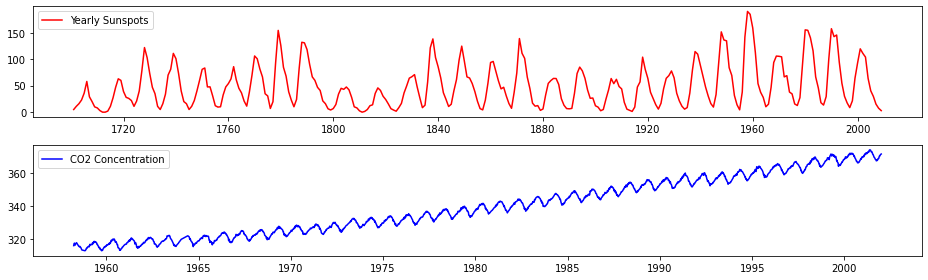

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(13,4))
ax1.plot(data_full1, color='r', label='Yearly Sunspots')
ax2.plot(data_full2, color='b', label='CO2 Concentration')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

## 3. Box–Jenkins Model Identification 

We plot the autocorrelations and partial autocorrelations for the lag of 50 for both datasets.

**Autocorrelation function** shows the degree of correlation of the same variables between two successive time intervals. It measures how the lagged version of the value of a variable is related to the original version of it in a time series. Autocorrelation, as a statistical concept, is also known as serial correlation [1].

**Partial autocorrelation function** is similar to the ACF except that it displays only the correlation between two observations that the shorter lags between those observations do not explain. For example, the partial autocorrelation for lag 3 is only the correlation that lags 1 and 2 do not explain. In other words, the partial correlation for each lag is the unique correlation between those two observations after partialling out the intervening correlations [2].

Typically, you will use the ACF to determine whether an autoregressive model is appropriate. If it is, you then use the PACF to help you choose the model terms.

[1] https://corporatefinanceinstitute.com/resources/knowledge/other/autocorrelation/#:~:text=Autocorrelation%20refers%20to%20the%20degree,also%20known%20as%20serial%20correlation.

[2] https://statisticsbyjim.com/time-series/autocorrelation-partial-autocorrelation/

For dataset1:


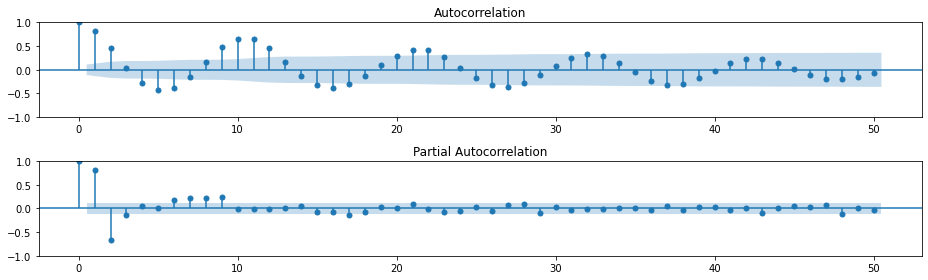

For dataset2:


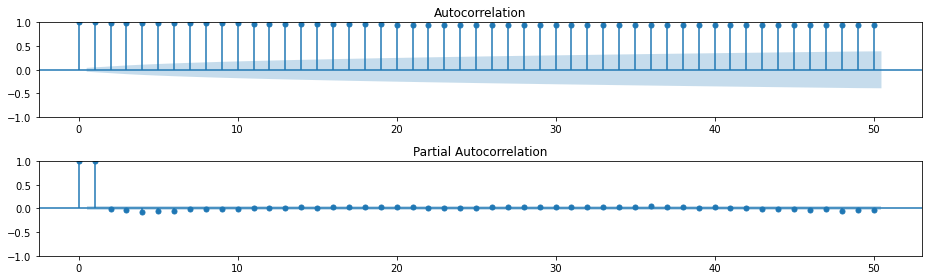

In [12]:
print('For dataset1:')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(13,4))
fig = sm.graphics.tsa.plot_acf(data_full1['SUNACTIVITY'], lags=50, ax=ax1)
fig = sm.graphics.tsa.plot_pacf(data_full1['SUNACTIVITY'], lags=50, ax=ax2, method='ywm')
plt.tight_layout() # to adjust the titles positions
plt.show()

print('For dataset2:')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(13,4))
fig = sm.graphics.tsa.plot_acf(data_full2['co2'], lags=50, ax=ax1)
fig = sm.graphics.tsa.plot_pacf(data_full2['co2'], lags=50, ax=ax2, method='ywm')
plt.tight_layout() # to adjust the titles positions
plt.show()

The following table summarizes how one can use the sample autocorrelation function (ACF) for model identification [1].

![ACF Interpretation Table](ACF_interpret.png)

[1] https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method

For dataset1, we are dealing with Case 7 because the decay is very slow. So, we need to remove the seasonality from the data and visualize the plots again. We define a function to remove the seasonality from the time series based on differentiation.

In [13]:
def Diff(data, distance):
    output = data[distance:].values - data[:-distance].values
    return output 

In [14]:
Distance = 11 # seasonal frequency of dataset1
data_full1_ds = pd.DataFrame(Diff(data_full1.reset_index(drop=True), Distance), columns=['SUNACTIVITY'], index=data_full1.index[Distance:])
data_full1_ds

,SUNACTIVITY
1711-12-31,-5.0
1712-12-31,-11.0
1713-12-31,-14.0
1714-12-31,-12.0
1715-12-31,-9.0
...,...
2004-12-31,-14.2
2005-12-31,-0.1
2006-12-31,-2.3
2007-12-31,-1.1


We plot dataset1 after removing the seasonality:

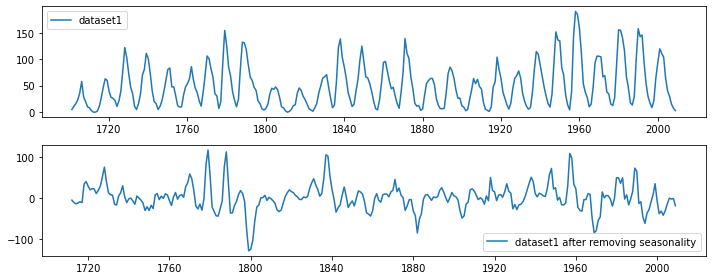

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,4))
ax1.plot(data_full1, label='dataset1')
ax2.plot(data_full1_ds, label='dataset1 after removing seasonality')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

Now, we plot the ACF and PACF again:

For dataset1 after detrending:


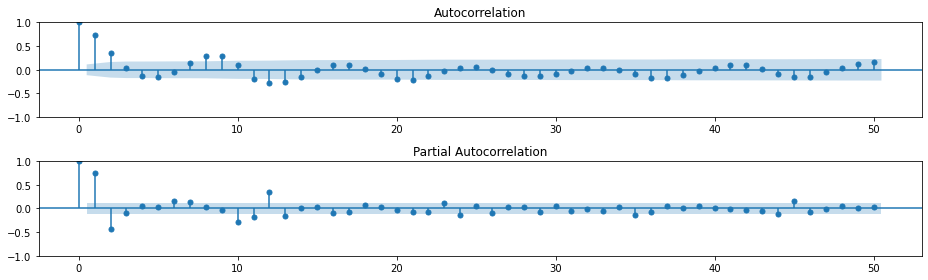

In [16]:
print('For dataset1 after detrending:')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(13,4))
fig = sm.graphics.tsa.plot_acf(data_full1_ds['SUNACTIVITY'], lags=50, ax=ax1)
fig = sm.graphics.tsa.plot_pacf(data_full1_ds['SUNACTIVITY'], lags=50, ax=ax2, method='ywm')
plt.tight_layout() # to adjust the titles positions
plt.show()

We check the autoregressive order auto select of the statsmodels:

In [17]:
ARSO = ar_select_order(endog=data_full1, maxlag=10,  glob=True, seasonal=True, period=11)
print(f'Final lag numbers by searching among the combinations of different lags are {ARSO.ar_lags}')

Final lag numbers by searching among the combinations of different lags are [1, 2, 9]


For dataset1 after removing the seasonality, we are dealing with Case 2. On the second graph of dataset1, the partial autocorrelations for lags 1 and 2 are statistically significant. Consequently, this PACF suggests fitting a second-order autoregressive model. The seasonal AR order can be 1 since PAC is significant only after 1 season.

For dataset2, we are dealing with Case 7. So, we need to remove the trend from the data and visualize the plots again. We detrend the time series based on differentiation.

In [18]:
Distance = 1
data_full2_dt = pd.DataFrame(Diff(data_full2.reset_index(drop=True), Distance), columns=['co2'], index=data_full2.index[Distance:])
data_full2_dt

,co2
1958-04-05,1.2
1958-04-12,0.3
1958-04-19,-0.1
1958-04-26,-1.1
1958-05-03,0.5
...,...
2001-12-01,0.0
2001-12-08,0.5
2001-12-15,0.4
2001-12-22,0.1


We plot dataset2 after detrending to see the difference:

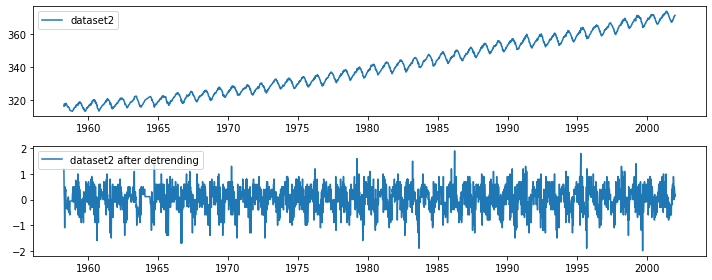

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,4))
ax1.plot(data_full2, label='dataset2')
ax2.plot(data_full2_dt, label='dataset2 after detrending')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

Now, we plot the ACF and PACF for dataset2 again:

For dataset2 after detrending:


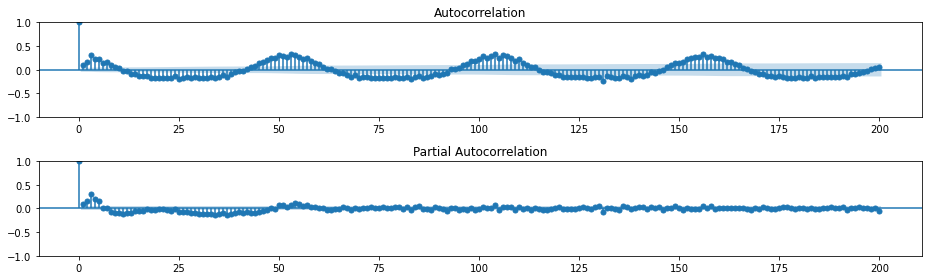

In [20]:
print('For dataset2 after detrending:')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(13,4))
fig = sm.graphics.tsa.plot_acf(data_full2_dt['co2'], lags=200, ax=ax1)
fig = sm.graphics.tsa.plot_pacf(data_full2_dt['co2'], lags=200, ax=ax2, method='ywm')
plt.tight_layout() # to adjust the titles positions
plt.show()

Now, it is Case 6. The seasonality can be seen not only in the line graph of 'data_full2_dt' but also in the above graphs. So, we remove the seasonality using differenciation with a distance of the seasonality frequency. For dataset2, this frequency is 1 year. Considering the temporal resolution of 1 week, the 'distance' should be 52 (1 year = 52 weeks).

In [21]:
Distance = 52
data_full2_dt_ds = pd.DataFrame(Diff(data_full2_dt.reset_index(drop=True), Distance), columns=['co2'], index=data_full2_dt.index[Distance:])
data_full2_dt_ds

,co2
1959-04-04,-0.2
1959-04-11,-0.9
1959-04-18,0.6
1959-04-25,1.8
1959-05-02,-0.6
...,...
2001-12-01,-0.7
2001-12-08,-0.1
2001-12-15,0.7
2001-12-22,-0.1


Now, we plot dataset2 after detrending and removing the seasonality.

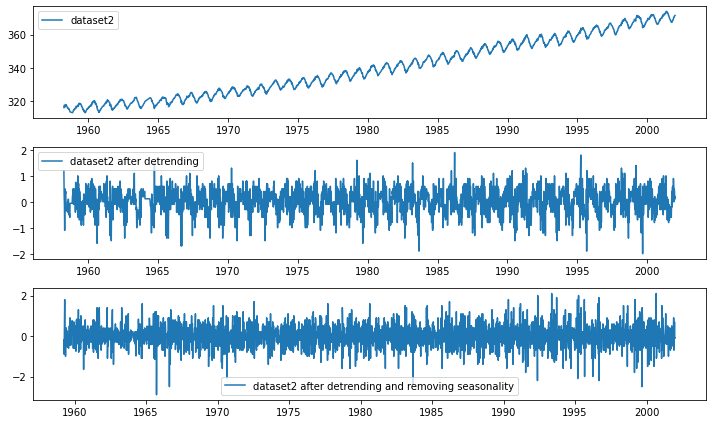

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,6))
ax1.plot(data_full2, label='dataset2')
ax2.plot(data_full2_dt, label='dataset2 after detrending')
ax3.plot(data_full2_dt_ds, label='dataset2 after detrending and removing seasonality')
ax1.legend()
ax2.legend()
ax3.legend()
plt.tight_layout()
plt.show()

We plot the new ACF and PACF for dataset2.

For dataset2 after detrending and removing seasonality:


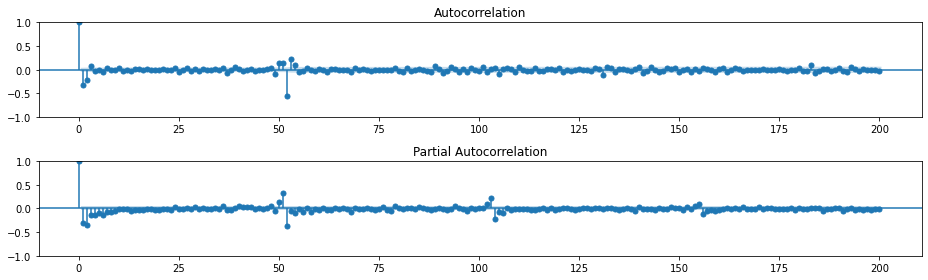

In [23]:
print('For dataset2 after detrending and removing seasonality:')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(13,4))
fig = sm.graphics.tsa.plot_acf(data_full2_dt_ds['co2'], lags=200, ax=ax1)
fig = sm.graphics.tsa.plot_pacf(data_full2_dt_ds['co2'], lags=200, ax=ax2, method='ywm')
plt.tight_layout() # to adjust the titles positions
plt.show()

We check the autoregressive order auto select of the statsmodels:

In [24]:
ARSO = ar_select_order(endog=data_full2, maxlag=10,  glob=True, trend='t', seasonal=True, period=52)
print(f'Final lag numbers by searching among the combinations of different lags are {ARSO.ar_lags}')

Final lag numbers by searching among the combinations of different lags are [1, 2, 3, 8]


For dataset2, we found that we need to develop a SARIMA model to consider the trend and seasonality of the data. Then, we can consider order of 3 for the autoregressive model. According to the above PACF, the seasonal AR order can be 2, since for 2 seasons, the values in the PACF plot are significant.

## 4. Model Development:

The most general form of the model is SARIMAX(p, d, q)x(P, D, Q, s). It also allows all specialized cases, including

- autoregressive models: AR(p)
- moving average models: MA(q)
- mixed autoregressive moving average models: ARMA(p, q)
- integration models: ARIMA(p, d, q)
- seasonal models: SARIMA(P, D, Q, s)
- regression with errors that follow one of the above ARIMA-type models

This model incorporates both exogenous regressors and trend components through “regression with ARIMA errors”.

More in: https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMA.html

We develope the first model on dataset1:

                                    SARIMAX Results                                     
Dep. Variable:                      SUNACTIVITY   No. Observations:                  309
Model:             ARIMA(2, 0, 0)x(1, 0, 0, 11)   Log Likelihood               -1299.810
Date:                          Sat, 17 Sep 2022   AIC                           2609.620
Time:                                  22:19:45   BIC                           2628.287
Sample:                              12-31-1700   HQIC                          2617.083
                                   - 12-31-2008                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.3136      4.919     10.026      0.000      39.673      58.954
ar.L1          1.2959      0.042     30.640      0.

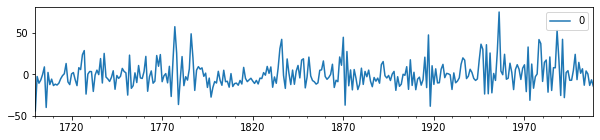

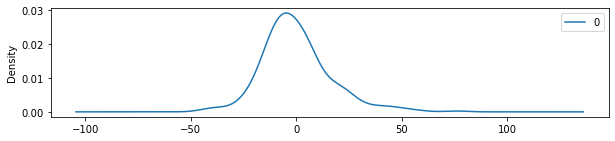

                0
count  309.000000
mean     0.036274
std     16.366434
min    -44.313575
25%    -10.323821
50%     -2.508581
75%      7.298325
max     75.900012


In [25]:
# fit model
model1_1 = ARIMA(data_full1, order=(2,0,0), seasonal_order=(1,0,0,11))
model1_1_fit = model1_1.fit()
# summary of fit model
print(model1_1_fit.summary())
# line plot of residuals
residuals1_1 = pd.DataFrame(model1_1_fit.resid)
residuals1_1.plot(figsize=(10,2))
plt.show()
# density plot of residuals
residuals1_1.plot(kind='kde', figsize=(10,2))
plt.show()
# summary stats of residuals
print(residuals1_1.describe())

We develop the second model on dataset 2:

                                    SARIMAX Results                                     
Dep. Variable:                              co2   No. Observations:                 2284
Model:             ARIMA(3, 1, 0)x(2, 0, 0, 52)   Log Likelihood               -1317.036
Date:                          Sat, 17 Sep 2022   AIC                           2646.071
Time:                                  22:20:13   BIC                           2680.471
Sample:                              03-29-1958   HQIC                          2658.618
                                   - 12-29-2001                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3497      0.020    -17.311      0.000      -0.389      -0.310
ar.L2         -0.2743      0.021    -12.818      0.

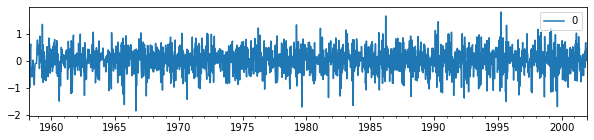

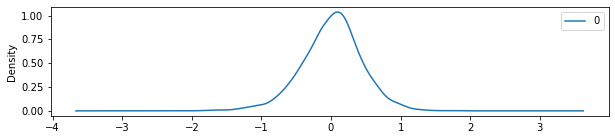

                 0
count  2283.000000
mean      0.011368
std       0.430495
min      -1.842821
25%      -0.237965
50%       0.032720
75%       0.270323
max       1.800157


In [26]:
# fit model
model2_1 = ARIMA(data_full2, order=(3,1,0), seasonal_order=(2,0,0,52)) 
model2_1_fit = model2_1.fit()
# summary of fit model
print(model2_1_fit.summary())
# line plot of residuals
residuals2_1 = pd.DataFrame(model2_1_fit.resid)[1:] # because of the order of differentiation
residuals2_1.plot(figsize=(10,2))
plt.show()
# density plot of residuals
residuals2_1.plot(kind='kde', figsize=(10,2))
plt.show()
# summary stats of residuals
print(residuals2_1.describe())

## 5. Evaluating The Residuals

### 5.1. ACF and PACF for Residuals:
We plot the ACF and PACF for the residuals of both models to see if there are strong correlations at lags.

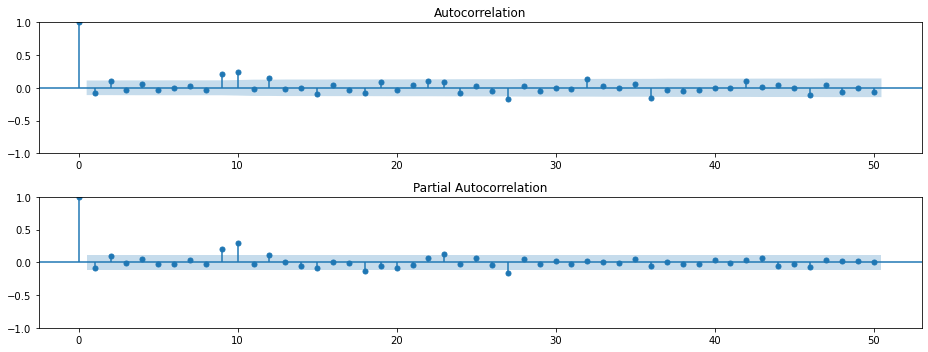

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(13,5))
fig = sm.graphics.tsa.plot_acf(residuals1_1.values, lags=50, ax=ax1)
fig = sm.graphics.tsa.plot_pacf(residuals1_1.values, lags=50, ax=ax2, method='ywm')
plt.tight_layout() # to adjust the titles positions

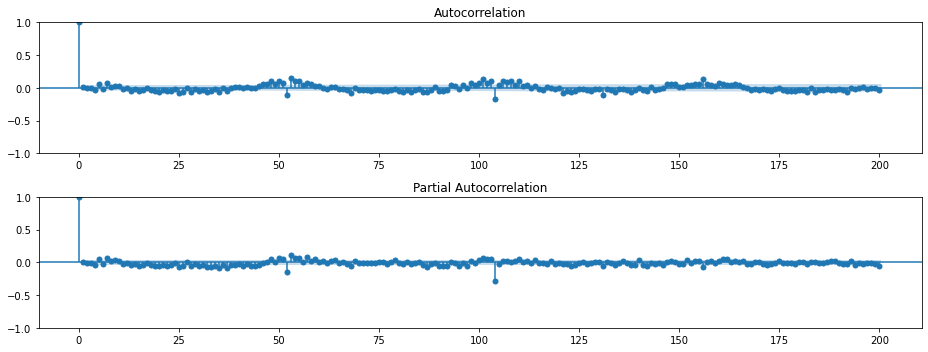

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(13,5))
fig = sm.graphics.tsa.plot_acf(residuals2_1.values, lags=200, ax=ax1)
fig = sm.graphics.tsa.plot_pacf(residuals2_1.values, lags=200, ax=ax2, method='ywm')
plt.tight_layout() # to adjust the titles positions

As can be seen, we have some values that can be considered significant. This can show a poor quality of fit.

### 5.2. Test of Normality for the residuals:
This helps us to find out if the residuals follow a normal distribution and hence are random or not.

In [29]:
print('For the residuals of model1_1: ', stats.normaltest(residuals1_1))
print('For the residuals of model2_1: ', stats.normaltest(residuals2_1))

For the residuals of model1_1:  NormaltestResult(statistic=array([54.20235409]), pvalue=array([1.69866741e-12]))
For the residuals of model2_1:  NormaltestResult(statistic=array([68.78899016]), pvalue=array([1.15520904e-15]))


'normaltest' returns a 2-tuple of the chi-squared statistic, and the associated p-value. Given the null hypothesis that x came from a normal distribution, the p-value represents the probability that a chi-squared statistic that large (or larger) would be seen.
If the p-val is very small, it means it is unlikely that the data came from a normal distribution.

### 5.3. Normal Q-Q Plots for the residuals:
Based on this plot, we can find out if the residuals follows a normal distribution.

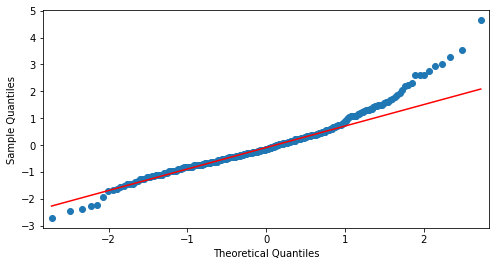

In [30]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
fig = qqplot(residuals1_1.sort_values(by=[0]).values, line="q", ax=ax, fit=True)

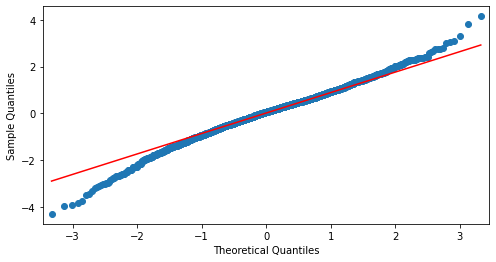

In [31]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
fig = qqplot(residuals2_1.sort_values(by=[0]).values, line="q", ax=ax, fit=True)

## 6. Adding a Moving Average Term to Previous Models:

We add MA(q=[9,10]) to the previous model developed for dataset1.

                                        SARIMAX Results                                        
Dep. Variable:                             SUNACTIVITY   No. Observations:                  309
Model:             ARIMA(2, 0, [9, 10])x(1, 0, [], 11)   Log Likelihood               -1277.192
Date:                                 Sat, 17 Sep 2022   AIC                           2568.385
Time:                                         22:27:11   BIC                           2594.518
Sample:                                     12-31-1700   HQIC                          2578.833
                                          - 12-31-2008                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.8161      7.493      6.515      0.000      34.131      63

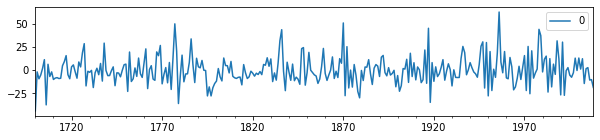

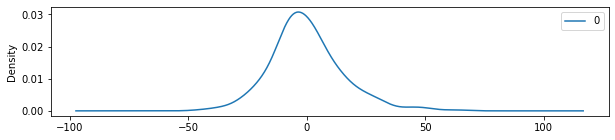

                0
count  309.000000
mean     0.049086
std     15.223017
min    -43.816131
25%     -8.797589
50%     -1.652810
75%      7.469317
max     63.168279


In [32]:
# fit model
model1_2 = ARIMA(data_full1, order=(2,0,[9,10]), seasonal_order=(1,0,0,11))
model1_2_fit = model1_2.fit()
# summary of fit model
print(model1_2_fit.summary())
# line plot of residuals
residuals1_2 = pd.DataFrame(model1_2_fit.resid)
residuals1_2.plot(figsize=(10,2))
plt.show()
# density plot of residuals
residuals1_2.plot(kind='kde', figsize=(10,2))
plt.show()
# summary stats of residuals
print(residuals1_2.describe())

We add MA(q=52) to the previous model developed for dataset2.

                                      SARIMAX Results                                       
Dep. Variable:                                  co2   No. Observations:                 2284
Model:             ARIMA(3, 1, [52])x(2, 0, [], 52)   Log Likelihood               -1087.327
Date:                              Sat, 17 Sep 2022   AIC                           2188.653
Time:                                      22:29:04   BIC                           2228.786
Sample:                                  03-29-1958   HQIC                          2203.290
                                       - 12-29-2001                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3888      0.020    -19.877      0.000      -0.427      -0.350
ar.L2         -0.30

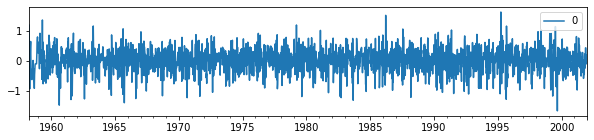

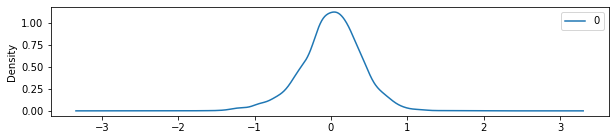

                 0
count  2283.000000
mean      0.007544
std       0.389954
min      -1.679214
25%      -0.208941
50%       0.024374
75%       0.252077
max       1.641763


In [33]:
# fit model
model2_2 = ARIMA(data_full2, order=(3,1,[52]), seasonal_order=(2,0,0,52)) 
model2_2_fit = model2_2.fit()
# summary of fit model
print(model2_2_fit.summary())
# line plot of residuals
residuals2_2 = pd.DataFrame(model2_2_fit.resid)[1:] # because of the order of differentiation
residuals2_2.plot(figsize=(10,2))
plt.show()
# density plot of residuals
residuals2_2.plot(kind='kde', figsize=(10,2))
plt.show()
# summary stats of residuals
print(residuals2_2.describe())

### 6.1. Comparing the Models: Information Criteria
An information criterion is a measure of the quality of a statistical model. It takes into account: (1) how well the model fits the data (2) the complexity of the model.Information criteria are used to compare alternative models fitted to the same data set. All else being equal, a model with a **lower** information criterion is superior to a model with a higher value [1].

Information criteria are computed using the following formula: <br>
IC = 2k - p*ln(L) <br>
where ln(L) is the Log-Likelihood, k is the number of Parameters in the model and p is a penalty factor. Widely used ICs are:

* **AIC:** <br>
The most widely used information criteria for predictive modeling is **Akaike's information criterion** which is usually referred to as the AIC. It employs a penalty factor of 2 and is thus: <br>
AIC = 2k - 2*ln(L)

* **BIC:** <br>
The most widely used information criteria for comparing Latent Class models is the **Baysian Information Criterion** which is usually referred to as the BIC. It is computed as: <br>
BIC = 2k - ln(n)*ln(L) <br>
where n is the sample size. 

* **HQIC:** <br>
The **Hannan–Quinn information criterion** is a criterion for model selection. It is an alternative to Akaike information criterion and Bayesian information criterion. It is given as [2]: <br>
HQIC = 2k*ln(ln(n)) - 2*ln(L)


[1] https://docs.displayr.com/wiki/Information_Criteria#:~:text=An%20information%20criterion%20is%20a,the%20complexity%20of%20the%20model.<br>
[2] https://www.vosesoftware.com/riskwiki/ComparingfittedmodelsusingtheSICHQICorAICinformationcritereon.php

In [34]:
print('For model1_1 - AIC, BIC, HQIC = ', model1_1_fit.aic, model1_1_fit.bic, model1_1_fit.hqic)
print('For model1_2 - AIC, BIC, HQIC = ', model1_2_fit.aic, model1_2_fit.bic, model1_2_fit.hqic)

For model1_1 - AIC, BIC, HQIC =  2609.6202343251307 2628.2869407096196 2617.083219131688
For model1_2 - AIC, BIC, HQIC =  2568.384875474347 2594.518264412631 2578.833054203528


In [35]:
print('For model2_1 - AIC, BIC, HQIC = ', model2_1_fit.aic, model2_1_fit.bic, model2_1_fit.hqic)
print('For model2_2 - AIC, BIC, HQIC = ', model2_2_fit.aic, model2_2_fit.bic, model2_2_fit.hqic)

For model2_1 - AIC, BIC, HQIC =  2646.0713871002404 2680.4708609794193 2658.6177309137893
For model2_2 - AIC, BIC, HQIC =  2188.653033663779 2228.7857531894874 2203.2904347795857


As can be seen above, adding a moving average term can have a considerable impact on the performance of the models.

### 6.2. Durbin Watson Statistic
The Durbin Watson (DW) statistic is a test for autocorrelation in the residuals from a statistical model or regression analysis. The Durbin-Watson statistic will always have a value ranging between 0 and 4. A value of 2.0 indicates there is no autocorrelation detected in the sample. Values from 0 to less than 2 point to positive autocorrelation and values from 2 to 4 means negative autocorrelation. A rule of thumb is that DW test statistic values in the range of 1.5 to 2.5 are relatively normal. Values outside this range could, however, be a cause for concern [1].

the Durbin–Watson statistic is a test statistic used to detect the presence of autocorrelation at lag 1 in the residuals (prediction errors) from a regression analysis. If $e_{t}$ is the residual given by $e_{t} = \rho e_{t-1} + v_{t}$, the Durbin-Watson test statistic is [2]:

![Image](https://wikimedia.org/api/rest_v1/media/math/render/svg/8f54d935596232863a9cfede2dfc6e426bd4b20a)

where $T$ is the number of observations. For large $T$, $d$ is approximately equal to $2(1 − \hat{\rho})$, where $\hat{\rho}$ is the sample autocorrelation of the residuals, $d = 2$ therefore indicates no autocorrelation.

[1] https://www.investopedia.com/terms/d/durbin-watson-statistic.asp<br>
[2] https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic

Method in https://www.statsmodels.org/dev/generated/statsmodels.stats.stattools.durbin_watson.html 

So, now we check this statistic for both developed models:

In [36]:
print(f'Durbin Watson statistic for model1_1 is {sm.stats.durbin_watson(model1_1_fit.resid.values)}')
print(f'Durbin Watson statistic for model1_2 is {sm.stats.durbin_watson(model1_2_fit.resid.values)}')

Durbin Watson statistic for model1_1 is 2.13478781793749
Durbin Watson statistic for model1_2 is 2.085436554419215


In [37]:
print(f'Durbin Watson statistic for model2_1 is {sm.stats.durbin_watson(model2_1_fit.resid.values)}')
print(f'Durbin Watson statistic for model2_2 is {sm.stats.durbin_watson(model2_2_fit.resid.values)}')

Durbin Watson statistic for model2_1 is 0.9966070935489503
Durbin Watson statistic for model2_2 is 0.9958221884944856


As can be seen, the residuals of the models developed on the first dataset have a DW statistic close to 2. However, this statistic for the second dataset is close to 1.  

## 7. Making Predictions:
We make predictions using the second models developed on the two datasets. The prediction intervals have been chosen arbitrarily. It should be noted that training and testing the models has to be performed on separate train-test datasets, which will be addressed later.

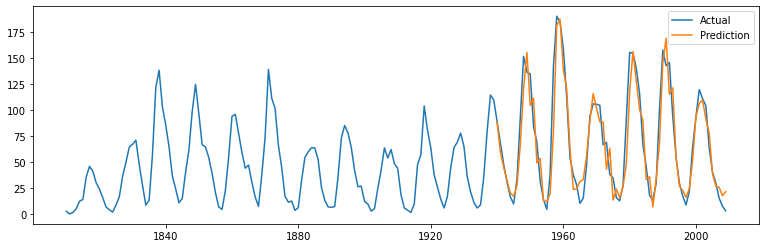

In [40]:
model1_2_pred = model1_2_fit.predict(start='1939', end='2008') 

# ploting the actual and predicted sunspots
plt.figure(figsize=(13,4))
plt.plot(data_full1[-200:], label='Actual')
plt.plot(model1_2_pred, label='Prediction')
plt.legend()
plt.show()

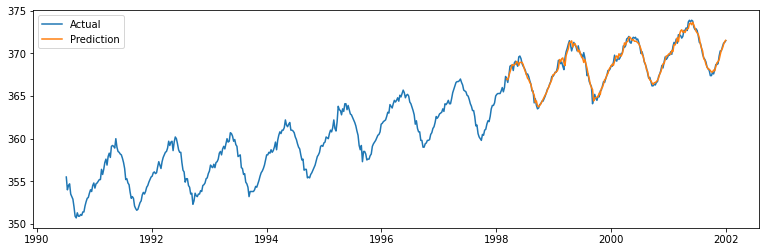

In [41]:
model2_2_pred = model2_2_fit.predict(start='1998-03-07', end='2001-12-29') 

# ploting the actual and predicted sunspots
plt.figure(figsize=(13,4))
plt.plot(data_full2[-600:], label='Actual')
plt.plot(model2_2_pred, label='Prediction')
plt.legend()
plt.show()

## 8. Rolling Forecast
First, we split the datasets into train-test sets and then implement a walk-forward testing where the model is updated each time step new data is received. In this approach, we forecast one step ahead over the test set and then add the actual known value of that step to the training set and fit the model again and repeat the procedure.

**For the first dataset:**

Test RMSE = 18.292728428621963


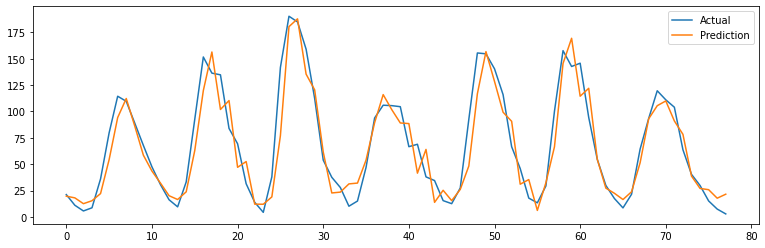

In [87]:
# train-test split
size = int(len(data_full1)*0.75) # considering the last 25% of data as test set
train1, test1 = data_full1.values[0:size], data_full1.values[size:]
history1 = [x for x in train1]  # after each forecast, observed true value will be added to this list and model will be trained on new data
predictions1 = list()

# walk-forward testing
for t in range(len(test1)):
    model = ARIMA(history1, order=(2,0,[9,10]), seasonal_order=(1,0,0,11))
    model_fit = model.fit()
    output = model_fit.forecast() #forecasting into one step ahead
    predictions1.append(output[0])
    history1.append(test1[t])
    #print(f'predicted={output[0]}, true value={test1[t]}')

# model evaluation
RMSE = sqrt(mean_squared_error(test1, predictions1))
print(f'Test RMSE = {RMSE}')

# visualising the forecasts
plt.figure(figsize=(13,4))
plt.plot(test1, label='Actual')
plt.plot(predictions1, label='Prediction')
plt.legend()
plt.show()

**For the second dataset:**

c:\Users\MIO\.conda\envs\envtf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\MIO\.conda\envs\envtf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\MIO\.conda\envs\envtf\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


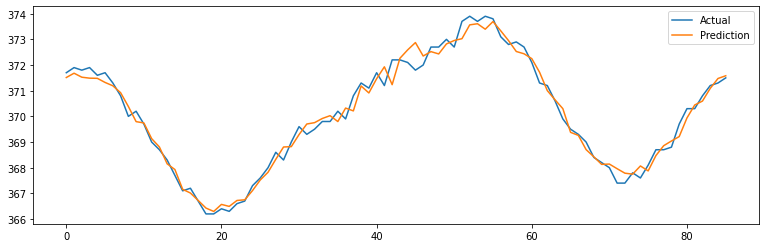

In [84]:
# creating a smaller dataset out of dataset2 since walk-forward testing takes very long time (almost 1 min for each time step)
data_full2_new = data_full2[int((3/4)*len(data_full2)):]

# train-test split
size = int(len(data_full2_new)*0.85) # considering the last 10% of data as test set
train2, test2 = data_full2_new.values[0:size], data_full2_new.values[size:]
history2 = [x for x in train2]  # after each forecast, observed true value will be added to this list and model will be trained on new data
predictions2 = list()

# walk-forward testing
for t in range(len(test2)):
    model = ARIMA(history2, order=(3,1,[52]), seasonal_order=(2,0,0,52))
    model_fit = model.fit()
    output = model_fit.forecast() #forecasting into one step ahead
    predictions2.append(output[0])
    history2.append(test2[t])
    #print(f'predicted={output[0]}, true value={test2[t]}')

# model evaluation
RMSE = sqrt(mean_squared_error(test2, predictions2))
print(f'Test RMSE = {RMSE}')

# visualising the forecasts
plt.figure(figsize=(13,4))
plt.plot(test2, label='Actual')
plt.plot(predictions2, label='Prediction')
plt.legend()
plt.show()

In [86]:
print(f'Test RMSE = {RMSE}')

Test RMSE = 0.3220997528906721


As can be seen, the predictions of the walk-forward testing are close to the real values and the RMSE values are acceptable considering the scale of the time series in both datasets.

## 9. Grid Search for Hyperparameters Tuning
In this section, we try to implement a grid search to automate the procedure to find the best order values for the model, instead of using the diagnostic plots of the time series along with heuristic rules.

First, we define a function for data splitting and model fitting:


In [25]:
def eval_model(data, train_size, p, d, q, P, D, Q, S):
    # train-test split
    size = int(len(data) * train_size) # considering the last 25% of data as test set
    train, test = data.values[0:size], data.values[size:]
    history = [x for x in train]  # after each forecast, observed true value will be added to this list and model will be trained on new data
    predictions = list()

    # walk-forward testing
    for t in range(len(test)):
        model = ARIMA(history, order=(p,d,q), seasonal_order=(P,D,Q,S))
        model_fit = model.fit()
        output = model_fit.forecast() #forecasting into one step ahead
        predictions.append(output[0])
        history.append(test[t])

    # model evaluation
    RMSE = sqrt(mean_squared_error(test, predictions))
    return RMSE

Checking the defined function based on the RMSE of the model developed for dataset1:

In [26]:
eval_model(data_full1, 0.75, p=2, d=0, q=[9,10], P=1, D=0, Q=0, S=11)

18.292728428621963

RMSE is the same as the previously obtained value.

Now, we iterate the above function over a grid search space specifying different values for the hyperparameters of the model. The function must keep track of the lowest error score observed and the configuration that caused it. 

In [27]:
def param_tuning(data, train_size, p_values, d_values, q_values, P_values, D_values, Q_values, S_values):
    data = data.astype('float32') # avoiding integers or strings since they cause procedure to fail
    best_rmse, best_param = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            for S in S_values:
                                try:
                                    error = eval_model(data, train_size, p, d, q, P, D, Q, S)
                                    if error < best_rmse:
                                        best_rmse, best_param = error, (p, d, q, P, D, Q, S)
                                    print(f'RMSE for (p, d, q, P, D, Q, S) of {(p, d, q, P, D, Q, S)} is {error}.') 
                                except:
                                    continue
    print(f'Best (p, d, q, P, D, Q, S) is {best_param} and best RMSE is {best_rmse}')  

Defigning a small search spapce for hyperparameters tuning on the first dataset: 

In [28]:
pval = [0, 1, 2, 4, 6]
dval = [0]
qval = range(8, 11)
Pval = [1]
Dval = [0]
Qval = [0]
Sval = [11]
warnings.filterwarnings("ignore") # to ignore warnings (like "Maximum Likelihood optimization failed to ") to avoid a lot of 
                                  # noise from running the procedure

param_tuning(data_full1, train_size=0.75, p_values=pval, d_values=dval, q_values=qval, 
             P_values=Pval, D_values=Dval, Q_values=Qval, S_values=Sval)

RMSE for (p, d, q, P, D, Q, S) of (0, 0, 8, 1, 0, 0, 11) is 21.083767790078184.
RMSE for (p, d, q, P, D, Q, S) of (0, 0, 9, 1, 0, 0, 11) is 19.74196301865361.
RMSE for (p, d, q, P, D, Q, S) of (0, 0, 10, 1, 0, 0, 11) is 18.973811262394836.
RMSE for (p, d, q, P, D, Q, S) of (1, 0, 8, 1, 0, 0, 11) is 21.52992228621465.
RMSE for (p, d, q, P, D, Q, S) of (1, 0, 9, 1, 0, 0, 11) is 21.13284016326796.
RMSE for (p, d, q, P, D, Q, S) of (1, 0, 10, 1, 0, 0, 11) is 19.11069720750724.
RMSE for (p, d, q, P, D, Q, S) of (2, 0, 8, 1, 0, 0, 11) is 19.651502897982514.
RMSE for (p, d, q, P, D, Q, S) of (2, 0, 9, 1, 0, 0, 11) is 18.61572298126521.
RMSE for (p, d, q, P, D, Q, S) of (2, 0, 10, 1, 0, 0, 11) is 18.559551366406875.
RMSE for (p, d, q, P, D, Q, S) of (4, 0, 8, 1, 0, 0, 11) is 19.35192517255379.
RMSE for (p, d, q, P, D, Q, S) of (4, 0, 9, 1, 0, 0, 11) is 18.688154303636303.
RMSE for (p, d, q, P, D, Q, S) of (4, 0, 10, 1, 0, 0, 11) is 18.651991987577638.
RMSE for (p, d, q, P, D, Q, S) of (6, 0, 8

We can apply the hyperparameters tuning to the model development for the second dataset. It should be noted that this can take a long time considering the dataset size, the search space size, and including the seasonal parameters.

--------------------
----------------------
END